In [19]:
# %% [markdown]
# #  Train và Đánh giá Mô hình TF-IDF
# 
# Notebook này thực hiện:
# - Train TF-IDF vectorizer
# - Đánh giá độ chính xác bằng nhiều phương pháp
# - Lưu model để sử dụng trong web app

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import sys
import os
import scipy.sparse as sp
# Thêm path để import từ src
sys.path.append('../src')
from preprocessing import load_and_process_data, preprocess_query

# %%
# 🔧 CONFIG
DATA_PATH = '../data/clean_movies.csv'
MODEL_SAVE_PATH = "../models/tfidf_vectorizer.pkl"
MATRIX_SAVE_PATH = "../models/tfidf_matrix.npy"

# %%
#  1. LOAD VÀ XỬ LÝ DỮ LIỆU
print(" Đang load dữ liệu...")
df = load_and_process_data(DATA_PATH)

print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Hiển thị 2 dòng đầu để kiểm tra
print("\nSample data:")
print(df[['title', 'genre', 'similarity_text']].head(2))

 Đang load dữ liệu...
--- Bắt đầu tạo cột văn bản đầu vào cho mô hình ---
--- Hoàn tất tạo văn bản xử lý ---
Shape: (9947, 11)
Columns: ['title', 'year', 'genre', 'rating', 'description', 'director', 'cast', 'poster', 'review', 'similarity_text', 'full_text']

Sample data:
                               title                      genre  \
0                    The Idea of You     Comedy, Drama, Romance   
1  Kingdom of the Planet of the Apes  Action, Adventure, Sci-Fi   

                                     similarity_text  
0  idea idea comedy drama romance comedy drama ro...  
1  kingdom planet apes kingdom planet apes action...  


 Phân tích dữ liệu text đã xử lý:
Độ dài trung bình similarity_text: 1541 ký tự


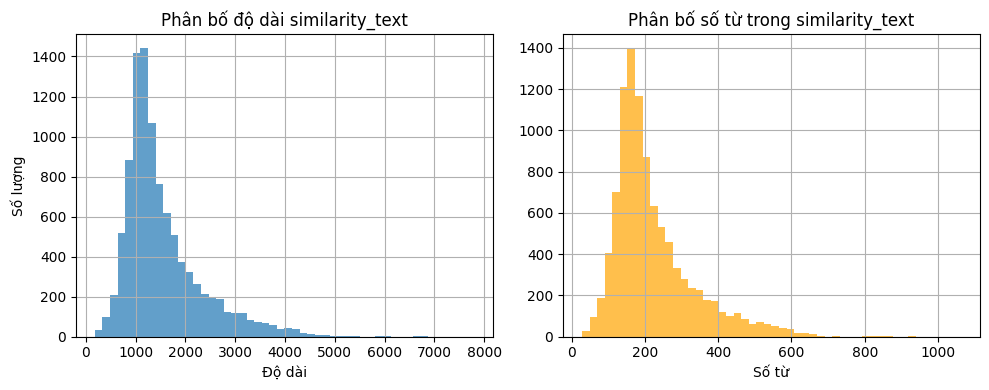

In [20]:

#  2. PHÂN TÍCH DỮ LIỆU ĐẦU VÀO
print(" Phân tích dữ liệu text đã xử lý:")

# Độ dài trung bình của similarity_text
df['text_length'] = df['similarity_text'].str.len()
print(f"Độ dài trung bình similarity_text: {df['text_length'].mean():.0f} ký tự")

# Phân bố độ dài
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['text_length'].hist(bins=50, alpha=0.7)
plt.title('Phân bố độ dài similarity_text')
plt.xlabel('Độ dài')
plt.ylabel('Số lượng')

plt.subplot(1, 2, 2)
df['similarity_text'].str.split().str.len().hist(bins=50, alpha=0.7, color='orange')
plt.title('Phân bố số từ trong similarity_text')
plt.xlabel('Số từ')
plt.tight_layout()
plt.show()

In [21]:
# %%
#  3. TRAIN TF-IDF MODEL
print(" Đang train TF-IDF model...")

tfidf = TfidfVectorizer(
    max_features=10000,      # Giới hạn số features
    min_df=2,                # Bỏ từ xuất hiện ít hơn 2 lần
    max_df=0.85,             # Bỏ từ xuất hiện nhiều hơn 85% documents
    ngram_range=(1, 2),      # Dùng cả unigram và bigram
    smooth_idf=True,
    sublinear_tf=True        # Áp dụng sublinear tf scaling
)

# Fit và transform
tfidf_matrix = tfidf.fit_transform(df['similarity_text'])
print(f" TF-IDF matrix shape: {tfidf_matrix.shape}")

 Đang train TF-IDF model...
 TF-IDF matrix shape: (9947, 10000)


In [22]:
# %%
# 💾 4. LƯU MODEL (Đã sửa lỗi MemoryError)
print(" Đang lưu model...")
os.makedirs('../models', exist_ok=True)

# 1. Lưu TF-IDF Vectorizer
joblib.dump(tfidf, MODEL_SAVE_PATH)

# 2. LƯU MA TRẬN THƯA (SPARSE MATRIX) bằng joblib
# Tránh dùng .toarray() và np.save vì chúng tạo ra ma trận dày đặc
joblib.dump(tfidf_matrix, MATRIX_SAVE_PATH)

print(f" Đã lưu: {MODEL_SAVE_PATH}")
print(f" Đã lưu ma trận SPARSE: {MATRIX_SAVE_PATH}")

 Đang lưu model...
 Đã lưu: ../models/tfidf_vectorizer.pkl
 Đã lưu ma trận SPARSE: ../models/tfidf_matrix.npy


In [4]:
# %%
# 🎯 5. HÀM TÌM KIẾM TF-IDF
def search_tfidf(query, tfidf_model, tfidf_matrix, df, top_k=10):
    """
    Tìm kiếm phim dựa trên query sử dụng TF-IDF
    """
    # Preprocess query 
    processed_query = preprocess_query(query, model_type='tfidf')
    
    # Transform query (query_vector sẽ là ma trận thưa 1 x V)
    query_vector = tfidf_model.transform([processed_query])
    
    # Tính similarity (Scikit-learn xử lý ma trận thưa tfidf_matrix rất nhanh)
    # Kết quả similarities là một NumPy array (dense) 1D
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    
    # Lấy top K indices
    # np.argsort hoạt động tốt với mảng dense similarities
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Tạo kết quả
    results = []
    for idx in top_indices:
        if similarities[idx] > 0: # Chỉ lấy kết quả có similarity > 0
            results.append({
                'title': df.iloc[idx]['title'],
                'genre': df.iloc[idx]['genre'],
                'similarity_score': similarities[idx],
                'original_index': idx
            })
    
    return results

In [14]:
# %%
# 🧪 6. ĐÁNH GIÁ ĐỘ CHÍNH XÁC - PHƯƠNG PHÁP 1: SELF-RETRIEVAL

def evaluate_self_retrieval(tfidf_model, tfidf_matrix, df, sample_size=50, top_k_list=[1, 5, 10]):
    """
    Đánh giá khả năng tìm lại chính phim từ title + genre của nó
    """
    print("🧪 ĐANG CHẠY SELF-RETRIEVAL TEST...")
    
    if sample_size > len(df):
        sample_size = len(df)
    
    # Lấy ngẫu nhiên sample_size phim để test
    test_indices = np.random.choice(len(df), size=sample_size, replace=False)
    
    results = {f'acc@{k}': [] for k in top_k_list}
    
    for i, idx in enumerate(test_indices):
        if i % 10 == 0:
            print(f"  Đang xử lý {i+1}/{sample_size}...")
            
        # Tạo query từ title + genre của phim (giống cách người dùng tìm)
        movie_title = df.iloc[idx]['title']
        movie_genre = df.iloc[idx]['genre']
        query = f"{movie_title} {movie_genre}"
        
        # Tìm kiếm
        search_results = search_tfidf(query, tfidf_model, tfidf_matrix, df, top_k=max(top_k_list))
        result_indices = [r['original_index'] for r in search_results]
        
        # Kiểm tra xem phim gốc có trong top K không
        for k in top_k_list:
            if idx in result_indices[:k]:
                results[f'acc@{k}'].append(1)
            else:
                results[f'acc@{k}'].append(0)
    
    # Tính accuracy
    print("\n📊 KẾT QUẢ SELF-RETRIEVAL TEST:")
    accuracy_results = {}
    for k in top_k_list:
        accuracy = np.mean(results[f'acc@{k}'])
        accuracy_results[f'acc@{k}'] = accuracy
        print(f"  ✅ Accuracy @ {k}: {accuracy:.4f} ({accuracy*100:.1f}%)")
    
    return accuracy_results
# Chạy self-retrieval test
self_retrieval_results = evaluate_self_retrieval(tfidf, tfidf_matrix, df)


🧪 ĐANG CHẠY SELF-RETRIEVAL TEST...
  Đang xử lý 1/50...
  Đang xử lý 11/50...
  Đang xử lý 21/50...
  Đang xử lý 31/50...
  Đang xử lý 41/50...

📊 KẾT QUẢ SELF-RETRIEVAL TEST:
  ✅ Accuracy @ 1: 0.4600 (46.0%)
  ✅ Accuracy @ 5: 0.6800 (68.0%)
  ✅ Accuracy @ 10: 0.8200 (82.0%)


In [15]:
# %%
# 🧪 7. ĐÁNH GIÁ ĐỘ CHÍNH XÁC - PHƯƠNG PHÁP 2: GENRE CONSISTENCY

def evaluate_genre_consistency(tfidf_model, tfidf_matrix, df, top_k=10):
    """
    Đánh giá tính nhất quán về thể loại
    """
    print("🧪 ĐANG CHẠY GENRE CONSISTENCY TEST...")
    
    # Tạo các truy vấn test theo genre
    test_queries = [
        {"query": "action movie", "expected_genre": "Action"},
        {"query": "romantic comedy", "expected_genre": "Romance"},
        {"query": "horror film", "expected_genre": "Horror"},
        {"query": "sci-fi adventure", "expected_genre": "Sci-Fi"},
        {"query": "drama story", "expected_genre": "Drama"},
    ]
    
    precision_scores = []
    detailed_results = []
    
    for test_case in test_queries:
        query = test_case["query"]
        expected_genre = test_case["expected_genre"]
        
        # Tìm kiếm
        results = search_tfidf(query, tfidf_model, tfidf_matrix, df, top_k=top_k)
        
        # Đếm số phim có genre mong muốn
        relevant_count = 0
        genre_matches = []
        
        for result in results:
            movie_genre = result['genre']
            if expected_genre.lower() in str(movie_genre).lower():
                relevant_count += 1
                genre_matches.append(1)
            else:
                genre_matches.append(0)
        
        precision = relevant_count / len(results) if results else 0
        precision_scores.append(precision)
        
        print(f"  🔍 '{query}' → Precision@{top_k}: {precision:.4f} ({relevant_count}/{len(results)})")
        
        detailed_results.append({
            'query': query,
            'expected_genre': expected_genre,
            'precision': precision,
            'relevant_count': relevant_count,
            'total_results': len(results)
        })
    
    avg_precision = np.mean(precision_scores)
    print(f"\n📊 KẾT QUẢ GENRE CONSISTENCY:")
    print(f"  ✅ Average Precision@{top_k}: {avg_precision:.4f} ({avg_precision*100:.1f}%)")
    
    return avg_precision, detailed_results

# Chạy genre consistency test
genre_avg_precision, genre_details = evaluate_genre_consistency(tfidf, tfidf_matrix, df)


🧪 ĐANG CHẠY GENRE CONSISTENCY TEST...
  🔍 'action movie' → Precision@10: 1.0000 (10/10)
  🔍 'romantic comedy' → Precision@10: 0.9000 (9/10)
  🔍 'horror film' → Precision@10: 0.8000 (8/10)
  🔍 'sci-fi adventure' → Precision@10: 1.0000 (10/10)
  🔍 'drama story' → Precision@10: 1.0000 (10/10)

📊 KẾT QUẢ GENRE CONSISTENCY:
  ✅ Average Precision@10: 0.9400 (94.0%)


In [16]:
# %%
# 🧪 8. ĐÁNH GIÁ ĐỘ CHÍNH XÁC - PHƯƠNG PHÁP 3: MANUAL TEST SAMPLES

def manual_evaluation_samples(tfidf_model, tfidf_matrix, df, num_queries=5):
    """
    Tạo các mẫu test để đánh giá thủ công (bằng mắt)
    """
    print(" TẠO MẪU ĐÁNH GIÁ THỦ CÔNG...")
    
    test_queries = [
        "action hero movie",
        "romantic love story", 
        "scary horror film",
        "funny comedy",
        "sci-fi space adventure"
    ]
    
    samples = []
    
    for query in test_queries[:num_queries]:
        results = search_tfidf(query, tfidf_model, tfidf_matrix, df, top_k=5)
        
        print(f"\n🔍 QUERY: '{query}'")
        print("Top 5 results:")
        for i, result in enumerate(results):
            print(f"  {i+1}. {result['title']} | {result['genre']} | Score: {result['similarity_score']:.4f}")
        
        samples.append({
            'query': query,
            'results': results
        })
    
    return samples

# Tạo mẫu đánh giá thủ công
manual_samples = manual_evaluation_samples(tfidf, tfidf_matrix, df)


 TẠO MẪU ĐÁNH GIÁ THỦ CÔNG...

🔍 QUERY: 'action hero movie'
Top 5 results:
  1. Pootie Tang | Action, Adventure, Comedy | Score: 0.2134
  2. Siren | Action, Crime, Thriller | Score: 0.1930
  3. Hercules | Animation, Action, Adventure | Score: 0.1753
  4. Capitán Avispa | Animation, Action, Adventure | Score: 0.1683
  5. Shazam! Fury of the Gods | Action, Adventure, Comedy | Score: 0.1670

🔍 QUERY: 'romantic love story'
Top 5 results:
  1. Bihter | Drama | Score: 0.2643
  2. Ask Filmi | Drama, Romance | Score: 0.2595
  3. The Architecture of Love | Drama, Romance | Score: 0.2171
  4. Teri Baaton Mein Aisa Uljha Jiya | Comedy, Drama, Romance | Score: 0.1888
  5. Love Story | Drama, Romance | Score: 0.1887

🔍 QUERY: 'scary horror film'
Top 5 results:
  1. Anaconda | Action, Adventure, Horror | Score: 0.1994
  2. Krampus | Comedy, Fantasy, Horror | Score: 0.1946
  3. Tamara | Drama, Fantasy, Horror | Score: 0.1858
  4. The Exorcism | Horror, Thriller | Score: 0.1847
  5. Scary Stories to T

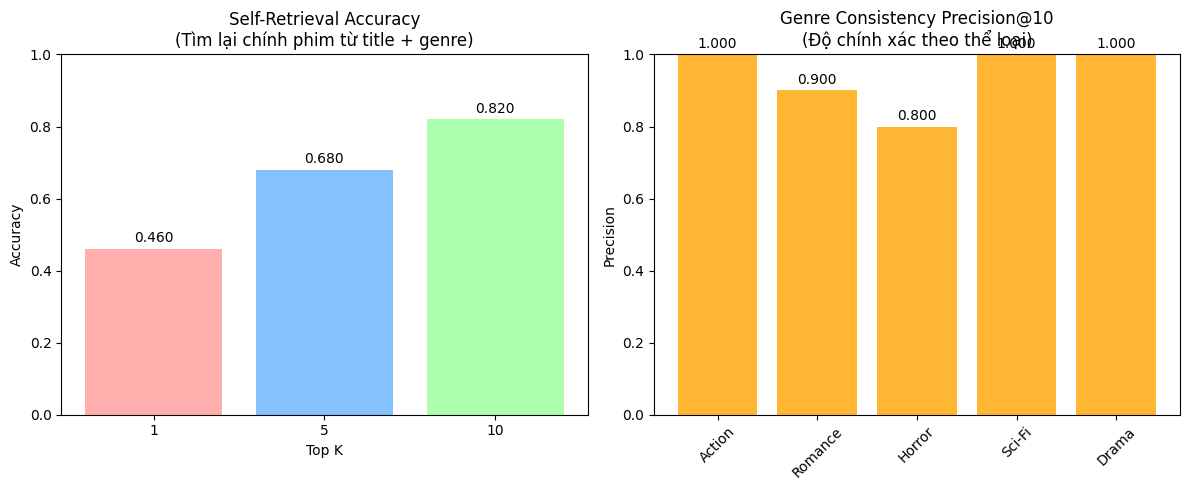


🎯 TỔNG HỢP KẾT QUẢ ĐÁNH GIÁ TF-IDF
📊 Self-Retrieval Accuracy:
   • Top 1: 0.4600 (46.0%)
   • Top 5: 0.6800 (68.0%)
   • Top 10: 0.8200 (82.0%)

📊 Genre Consistency:
   • Average Precision@10: 0.9400 (94.0%)

📁 Model đã được lưu tại:
   • TF-IDF Vectorizer: ../models/tfidf_vectorizer.pkl
   • TF-IDF Matrix: ../models/tfidf_matrix.npy


In [17]:
# %%
# 📈 9. VẼ BIỂU ĐỒ KẾT QUẢ

def plot_evaluation_results(self_retrieval_results, genre_avg_precision):
    """
    Visualization kết quả đánh giá
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Biểu đồ 1: Self-Retrieval Accuracy
    k_values = [1, 5, 10]
    acc_values = [self_retrieval_results[f'acc@{k}'] for k in k_values]
    
    bars1 = ax1.bar([str(k) for k in k_values], acc_values, 
                   color=['#ff9999', '#66b3ff', '#99ff99'], alpha=0.8)
    ax1.set_title('Self-Retrieval Accuracy\n(Tìm lại chính phim từ title + genre)', fontsize=12)
    ax1.set_xlabel('Top K')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    
    # Thêm giá trị lên biểu đồ
    for bar, value in zip(bars1, acc_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')
    
    # Biểu đồ 2: Genre Consistency
    genres = ['Action', 'Romance', 'Horror', 'Sci-Fi', 'Drama']
    genre_precisions = [detail['precision'] for detail in genre_details]
    
    bars2 = ax2.bar(genres, genre_precisions, color='orange', alpha=0.8)
    ax2.set_title('Genre Consistency Precision@10\n(Độ chính xác theo thể loại)', fontsize=12)
    ax2.set_ylabel('Precision')
    ax2.set_ylim(0, 1)
    plt.xticks(rotation=45)
    
    # Thêm giá trị lên biểu đồ
    for bar, value in zip(bars2, genre_precisions):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('../docs/design/tfidf_evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # In kết quả tổng hợp
    print("\n" + "="*50)
    print("🎯 TỔNG HỢP KẾT QUẢ ĐÁNH GIÁ TF-IDF")
    print("="*50)
    print(f"📊 Self-Retrieval Accuracy:")
    for k in [1, 5, 10]:
        print(f"   • Top {k}: {self_retrieval_results[f'acc@{k}']:.4f} ({self_retrieval_results[f'acc@{k}']*100:.1f}%)")
    
    print(f"\n📊 Genre Consistency:")
    print(f"   • Average Precision@10: {genre_avg_precision:.4f} ({genre_avg_precision*100:.1f}%)")
    
    print(f"\n📁 Model đã được lưu tại:")
    print(f"   • TF-IDF Vectorizer: {MODEL_SAVE_PATH}")
    print(f"   • TF-IDF Matrix: {MATRIX_SAVE_PATH}")

# Vẽ biểu đồ và tổng kết
plot_evaluation_results(self_retrieval_results, genre_avg_precision)
